## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiances.nc')

In [3]:
# Only take the MSPI observations for the retrieval
sensors.popitem('eMAS')
# Keep these two cameras for cross-validation
ground_camera = sensors.popitem('GroundCamera')
side_camera = sensors.popitem('SideViewCamera')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [24]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [25]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.86].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
    rte_grid,'cloud', 0.86,optical_properties
)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    extinction=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

In [26]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [27]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [28]:
# transform initial physical state to abstract state. 
initial_gridded_extinction = carved_volume.mask.data.astype(float)*1.0
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['extinction'].state_to_grid.inverse_transform(initial_gridded_extinction)
x0 = state_gen._unknown_scatterers['cloud'].variables['extinction'].coordinate_transform.inverse_transform(initial_1d_extinction)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -1.857  0.102E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     2  -3.890  0.101E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     3  -6.321  0.101E-02    31968    72.73  0.284   [Radiance 0.860 micron]
 ! Iterations:      3     Final Criterion:  0.000000   [Radiance 0.860 micron]


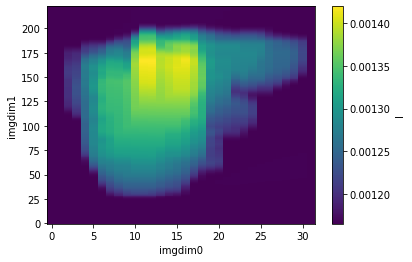

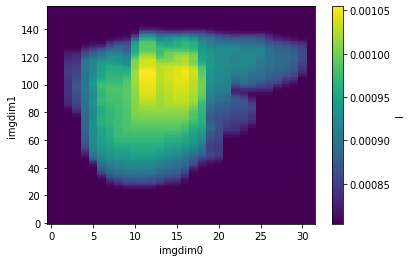

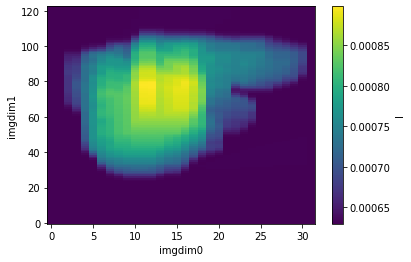

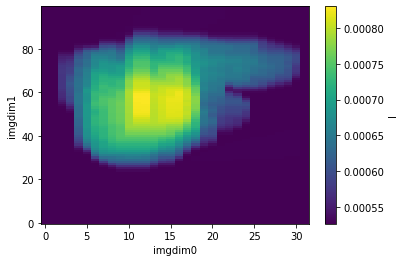

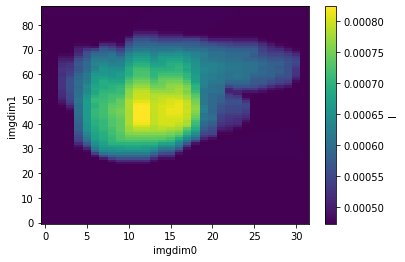

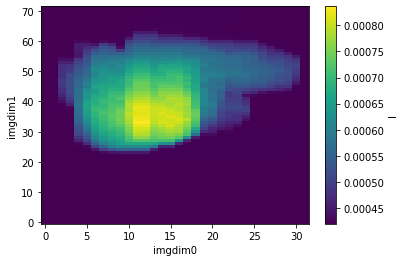

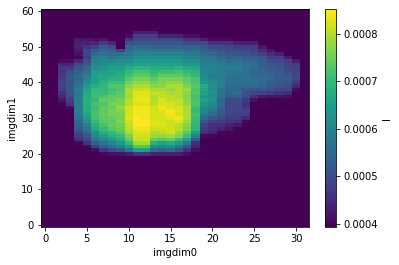

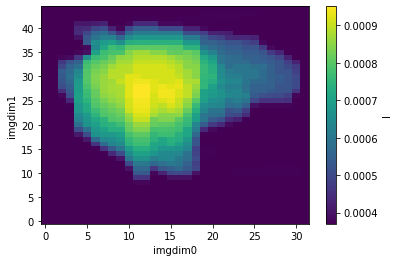

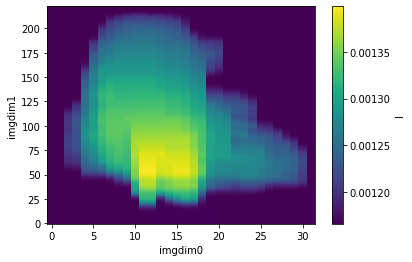

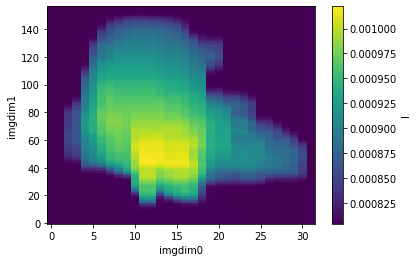

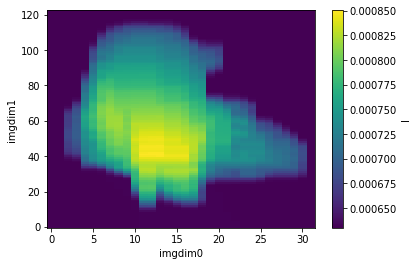

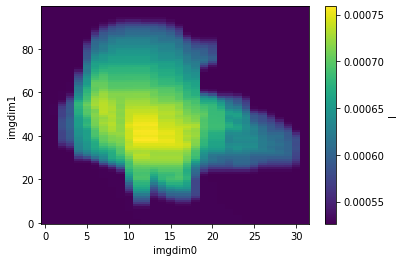

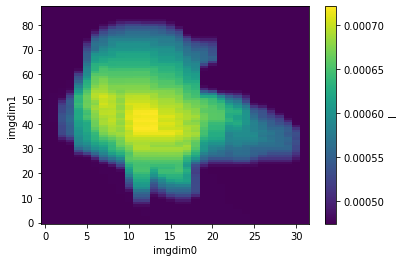

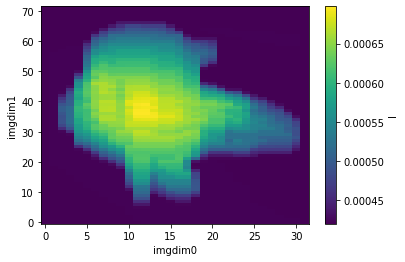

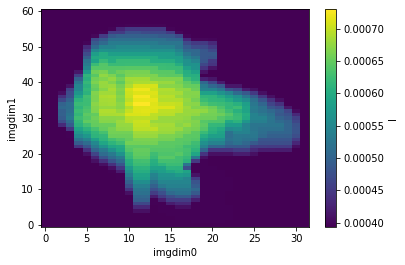

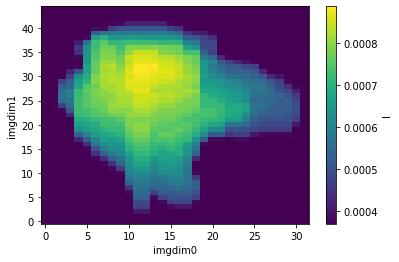

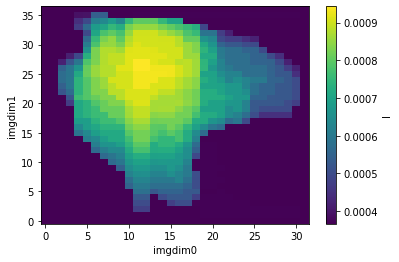

In [9]:
#visualize the initial state
state_gen(x0)
forward_sensors.get_measurements(solvers_reconstruct)

for instrument in forward_sensors:
    for im in forward_sensors.get_images(instrument):
        py.figure()
        im.I.T.plot()

In [29]:

objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [30]:
%matplotlib inline
def plot():
    py.figure()
    py.plot(solvers_reconstruct[0.86].medium['cloud'].extinction.data.ravel(), 
            solvers[0.86].medium['cloud'].extinction.data.ravel(),'x')
    py.plot([0,130],[0,130])
callback = at3d.callback.CallbackFn(plot)

In [34]:

optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.999  0.108E-01    31968    72.73  0.284   [Radiance 0.860 micron]
     2  -2.068  0.101E-01    31968    72.73  0.284   [Radiance 0.860 micron]
     3  -3.454  0.101E-01    31968    72.73  0.284   [Radiance 0.860 micron]
     4  -4.655  0.101E-01    31968    72.73  0.284   [Radiance 0.860 micron]
 ! Iterations:      4     Final Criterion:  0.000022   [Radiance 0.860 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8248     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17094D+02    |proj g|=  4.33877D-03
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.998  0.108E-01    31968    72.73  0.284   [Radiance 0.860 micron]
     2  -2.067  0.101E-01    31968    72.73  0.284   [Radiance 0.860 micron]
     3  -3.451  0.101E-01    31968    72.73  0.284   [Radiance 0.860 micron]
     

    15  -4.845  0.300E-01    42998   103.94  0.406   [Radiance 0.860 micron]
 ! Iterations:     15     Final Criterion:  0.000014   [Radiance 0.860 micron]

At iterate    7    f=  1.12581D+01    |proj g|=  1.49413D-03
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.684  0.298E+00    31968    58.87  0.230   [Radiance 0.860 micron]
     2  -1.223  0.328E+00    31968    58.87  0.230   [Radiance 0.860 micron]
     3  -1.597  0.330E+00    31968    58.87  0.230   [Radiance 0.860 micron]
     4  -1.878  0.240E+00    32040    59.32  0.232   [Radiance 0.860 micron]
     5  -2.349  0.142E+00    32360    61.11  0.239   [Radiance 0.860 micron]
     6  -2.389  0.747E-01    33988    69.49  0.271   [Radiance 0.860 micron]
     7  -2.427  0.526E-01    36570    81.74  0.319   [Radiance 0.860 micron]
     8  -2.619  0.428E-01    38733    90.68  0.354   [Radiance 0.860 micron]
     9  -2.649  0.332E-01    42555   104.39  0.408   [Radiance 0.860 micron]
    10  -2.818 

    15  -4.059  0.302E-01    50606   127.01  0.496   [Radiance 0.860 micron]
 ! Iterations:     15     Final Criterion:  0.000087   [Radiance 0.860 micron]

At iterate   13    f=  4.34905D+00    |proj g|=  6.52087D-04
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.689  0.397E+00    31968    57.33  0.224   [Radiance 0.860 micron]
     2  -1.236  0.437E+00    31968    57.33  0.224   [Radiance 0.860 micron]
     3  -1.598  0.452E+00    31968    57.33  0.224   [Radiance 0.860 micron]
     4  -1.868  0.309E+00    32008    57.57  0.225   [Radiance 0.860 micron]
     5  -2.315  0.172E+00    32386    59.82  0.234   [Radiance 0.860 micron]
     6  -2.306  0.862E-01    34440    70.61  0.276   [Radiance 0.860 micron]
     7  -2.348  0.615E-01    37249    83.94  0.328   [Radiance 0.860 micron]
     8  -2.523  0.501E-01    39642    93.65  0.366   [Radiance 0.860 micron]
     9  -2.550  0.388E-01    44290   109.68  0.428   [Radiance 0.860 micron]
    10  -2.651 

    10  -2.630  0.348E-01    48783   121.00  0.473   [Radiance 0.860 micron]
    11  -2.723  0.300E-01    53444   131.75  0.515   [Radiance 0.860 micron]
    12  -3.027  0.300E-01    53608   132.03  0.516   [Radiance 0.860 micron]
    13  -3.254  0.301E-01    53608   132.03  0.516   [Radiance 0.860 micron]
    14  -3.386  0.301E-01    53608   132.03  0.516   [Radiance 0.860 micron]
    15  -3.917  0.301E-01    53608   132.03  0.516   [Radiance 0.860 micron]
    16  -4.171  0.301E-01    53608   132.03  0.516   [Radiance 0.860 micron]
 ! Iterations:     16     Final Criterion:  0.000068   [Radiance 0.860 micron]

At iterate   19    f=  3.35252D+00    |proj g|=  3.28039D-04
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.690  0.425E+00    31968    56.53  0.221   [Radiance 0.860 micron]
     2  -1.239  0.473E+00    31968    56.53  0.221   [Radiance 0.860 micron]
     3  -1.602  0.494E+00    31968    56.53  0.221   [Radiance 0.860 micron]
     4  -1.871 

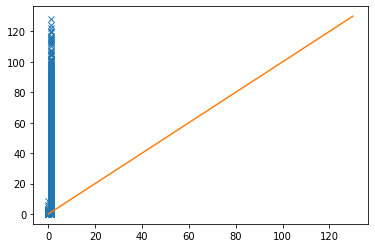

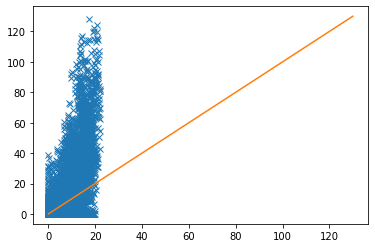

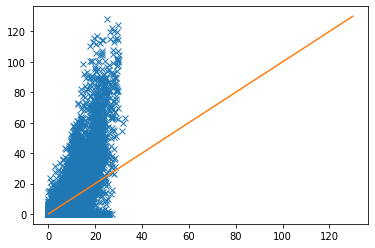

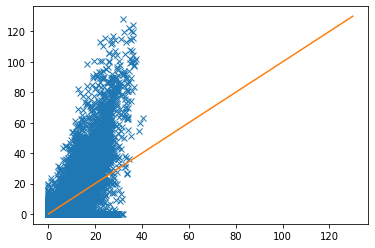

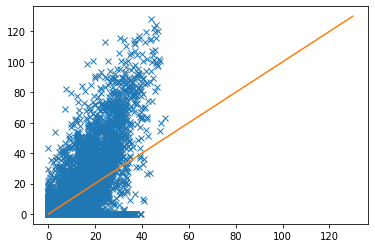

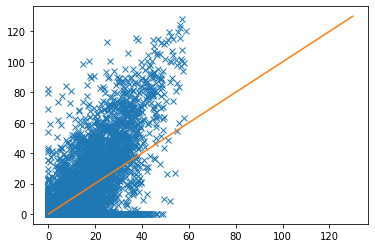

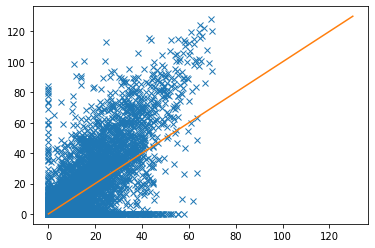

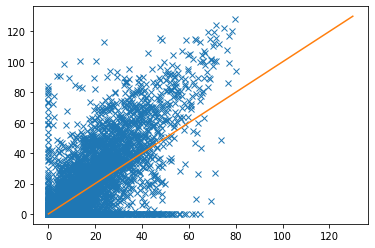

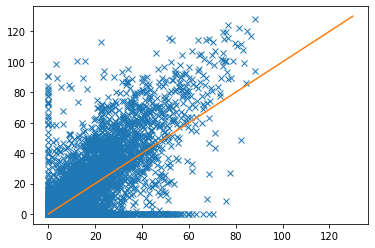

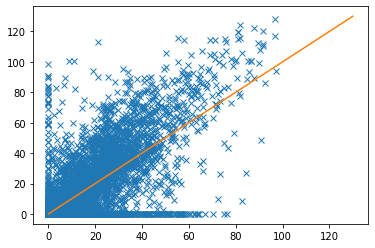

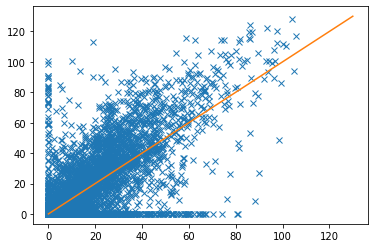

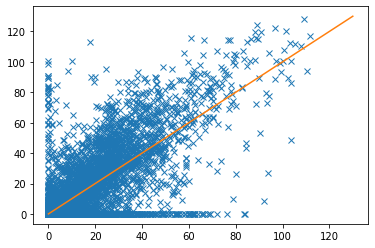

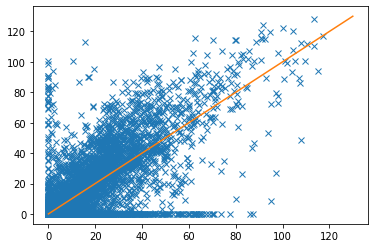

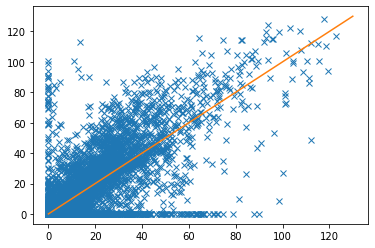

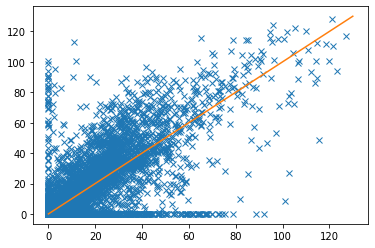

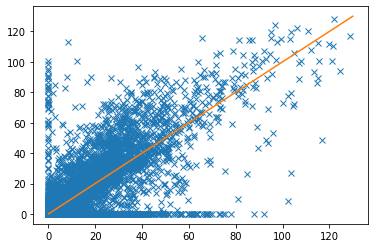

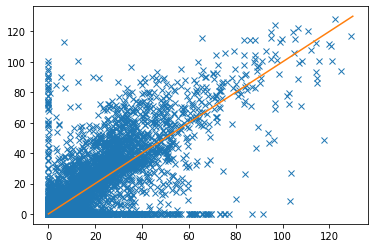

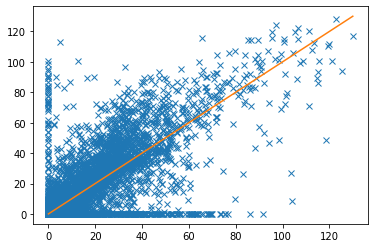

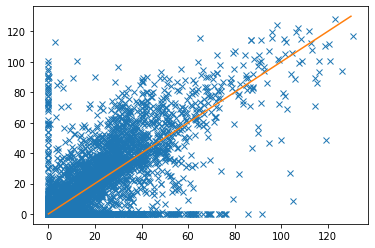

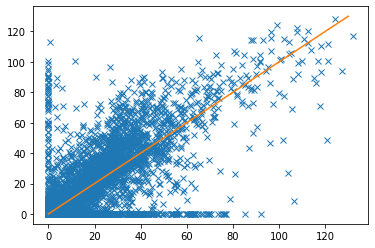

In [35]:
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 20
result = optimizer.minimize(x0)

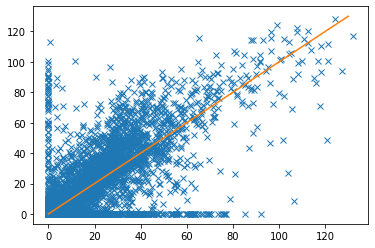

In [36]:
# Take a look  at the result.
py.figure()
py.plot(solvers_reconstruct[0.86].medium['cloud'].extinction.data.ravel(), 
        solvers[0.86].medium['cloud'].extinction.data.ravel(),'x')
py.plot([0,130],[0,130])

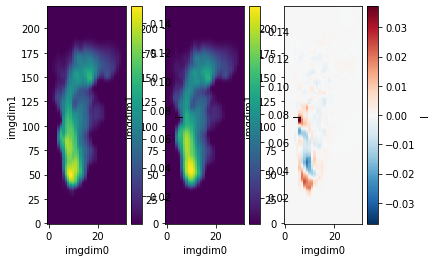

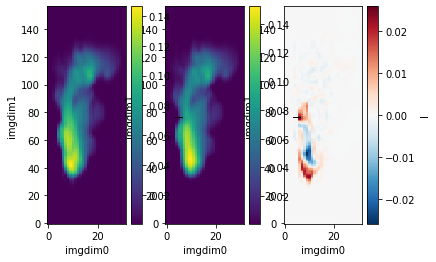

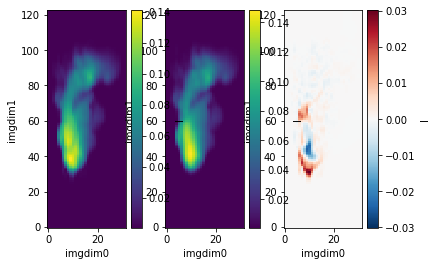

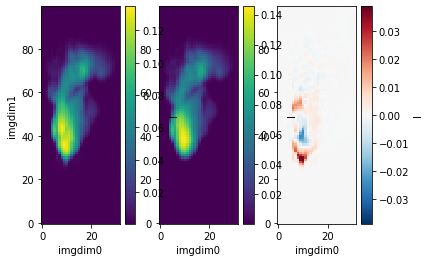

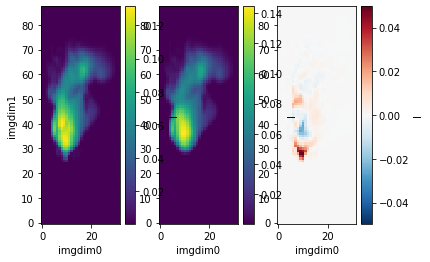

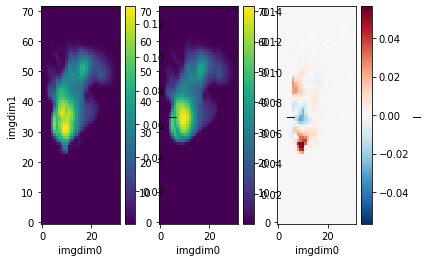

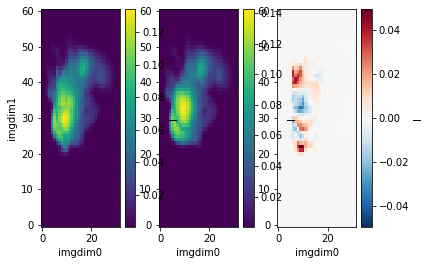

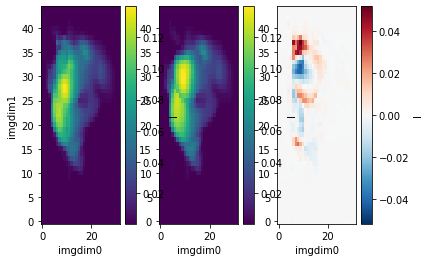

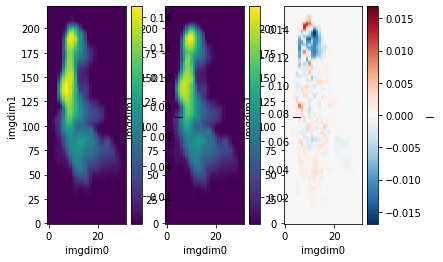

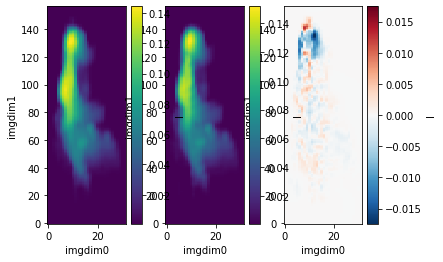

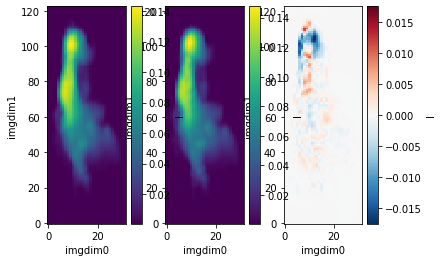

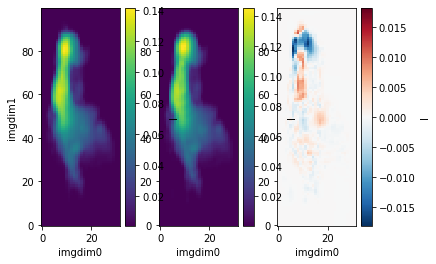

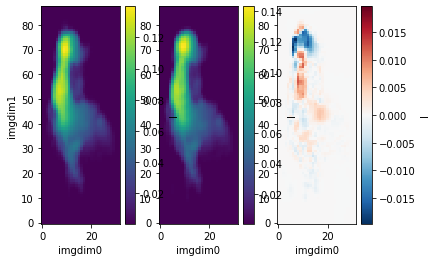

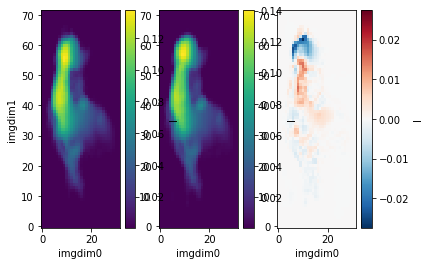

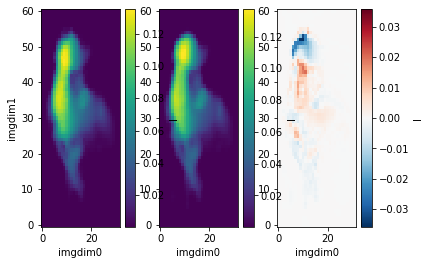

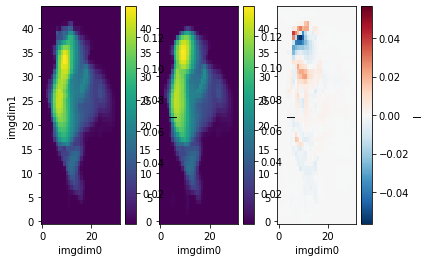

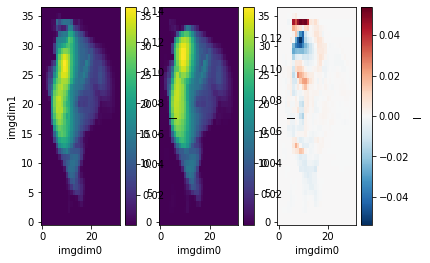

In [37]:
for instrument in forward_sensors:
    for im1,im2 in zip(forward_sensors.get_images(instrument),
                       sensors.get_images(instrument)):
        fig,ax = py.subplots(1,3)
        im1.I.T.plot(ax=ax[0])
        im2.I.T.plot(ax=ax[1])
        (im1.I-im2.I).T.plot(ax=ax[2])

While we have only performed a limited optimization and decreased the cost function by a factor of ~100, the images are already quite similar.
Despite this similarity in image space there are substantial differences in the retrieved extinction field. In some cases, this looks like some noisy voxels and in others it looks like the structure is fundamentally different.These differences are not well-constrained by the measurements but will continue to improve if we continue the optimization process.

Additionally, convergence may be accelerated and the reconstructed state made more accurate through the inclusion of regularization. A number of regularization terms are included in `regularization.py` and can be added to the optimizer as a list of callable objects through the `prior_fn` argument.
The optimal choice of regularization terms is still a subject of study and a future tutorial will cover these aspects as they become better understood.

<IPython.core.display.Javascript object>


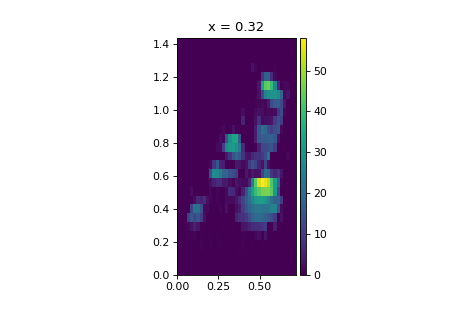

interactive(children=(IntSlider(value=15, description='frame', max=31), Output()), _dom_classes=('widget-inter…

In [42]:
%matplotlib notebook
solvers_reconstruct[0.86].medium['cloud'].extinction.visualization.slider('x')
#solvers[0.86].medium['cloud'].extinction.visualization.animate('x')

<IPython.core.display.Javascript object>


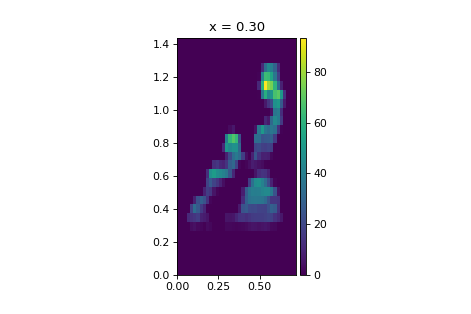

interactive(children=(IntSlider(value=15, description='frame', max=31), Output()), _dom_classes=('widget-inter…

In [41]:
%matplotlib notebook
solvers[0.86].medium['cloud'].extinction.visualization.slider('x')

In [ ]:
# Optionally continue the optimization process.
#
# Note that restarting like this is less effective than continuing as there will be
# loss of information about cost function curvature.
# This will likely require extensive line searching during the first, 
# or possibly several, iterations.
#optimizer._options['maxiter'] = 100
#updated_result = optimizer.minimize(state_gen.get_state())